In [35]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [36]:
img = io.read_image('puppy.jpg')
print(img.shape)

torch.Size([3, 1200, 1800])


In [37]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

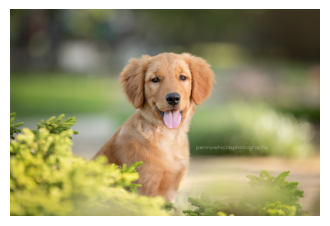

In [38]:
show_img(img)

In [39]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [40]:
%pip install -q wurlitzer ninja

In [41]:
%load_ext wurlitzer

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


In [42]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [43]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

In [44]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options());
    int threads = 256;
    rgb_to_grayscale_kernel<<<cdiv(w*h,threads), threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [45]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [46]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /root/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
No modifications detected for re-loaded extension module inline_ext, skipping build step...
Loading extension module inline_ext...


In [47]:
dir(module)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'rgb_to_grayscale']

In [48]:
imgc = img.contiguous().cuda()

In [49]:
%%time
res = module.rgb_to_grayscale(imgc).cpu()
h,w = res.shape
h,w,h*w

CPU times: user 2.25 ms, sys: 40 µs, total: 2.29 ms
Wall time: 4.22 ms
h*w: 1200*1800


(1200, 1800, 2160000)

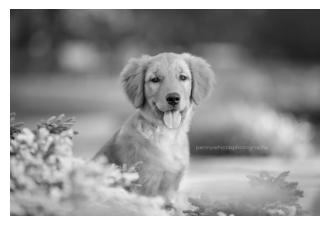

In [50]:
show_img(res, cmap='gray')